In [1]:
import lib.csv_helpers as csv
from IPython.display import display

## Save Dummy Data for all elements into tsv folder structure


In [10]:

import dummydata

print("Generating Dummy tsv files with the following settings")
run_settings = dummydata.defaults

run_settings['instrument']['sensor'] = 'DUM01'

chem_map = dummydata.dummyChemistry(run_settings)
run_settings['instrument']['chemistry_map'] = chem_map

display(run_settings)

dummydata.generate_tsv(run_settings, append=False)

# print("appending another data set with new sensor name")
# run_settings['instrument']['sensor'] = 'DUM02'
# dummydata.generate_tsv(run_settings, append=True)


Generating Dummy tsv files with the following settings


{'filename': 'test.hdf5',
 'output_dir': './raw',
 'instrument': {'name': 'Lab_setup_02',
  'sensor': 'DUM01',
  'element_rows': 4,
  'element_cols': 4,
  'chemistry_map': {'A01': 'Zirconium',
   'A02': 'Gallium',
   'A03': 'Titanium',
   'A04': 'Xenon',
   'B01': 'Iodine',
   'B02': 'Calcium',
   'B03': 'Xenon',
   'B04': 'Rubidium',
   'C01': 'Lanthanum',
   'C02': 'Beryllium',
   'C03': 'Arsenic',
   'C04': 'Helium',
   'D01': 'Yttrium',
   'D02': 'Neodymium',
   'D03': 'Neon',
   'D04': 'Tin'},
  'light Source': 'Stellarnet LED White',
  'spectrometer': 'Stellarnet BlueWave VIS-25'},
 'fluid_list': ['water', 'beer1', 'beer2'],
 'wavelength_range': [400, 420, 0.5],
 'elements': 'all',
 'repeats': 3}

## Preview of csv spectrometer data

In [11]:
import os
import pandas as pd
dir = "/Users/calum/git/Glasgow/sampleData/Beer x Bitter"
testfile = "HAN24_Sensor10_BeerBitter1_Rotation1.txt"
df = pd.read_csv(os.path.join(dir, testfile), sep='\t')

#label columns
reps = len(df.columns)-1
col_names = ['wavelength']
for r in range(reps):
	col_names.append(F"rep{r+1}")
df.columns = col_names
df

,wavelength,rep1,rep2,rep3
0,457.131,98.77,99.22,98.77
1,457.204,99.00,99.16,98.96
2,457.277,95.12,95.17,94.66
3,457.349,93.82,93.88,93.54
4,457.422,93.98,94.03,93.78
...,...,...,...,...
4090,730.534,66.20,65.54,66.02
4091,730.598,66.68,66.14,66.71
4092,730.661,67.71,67.92,67.83
4093,730.724,66.41,67.32,66.72


## Import from .txt or .csv files

### Input File

Requires a text file with at least 2 columns.
(They don't need to be named in the file)

[wavelength]	[transmission data 1]	...[transmission data n (optional)]

The default is for tab separation, but can be specified with:

separator = '\t'

### Regex
A regex must be provided to identify these metadata fields from the filename:
* sensor
* element
* fluid

Optional, will be preserved in the metadata:
* rotation


In [1]:
import lib.csv_helpers as csv
#Folder containing text/csv files to import
# import_dir = "/Users/calum/git/Glasgow/sampleData/Beer x Bitter"
input_dir = "/Users/calum/git/Glasgow/sampleData/combined"
output_dir = 'sampledata'

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(.+).txt'

csv.import_dir_to_csv(input_dir, regex, output_dir, append=False)





INFO:root:imported HAN24_Sensor10_BeerBitter1_Rotation1.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter1-10.tsv
INFO:root:imported HAN24_Sensor10_BeerBitter1_Rotation2.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter1-10.tsv
INFO:root:imported HAN24_Sensor10_BeerBitter2_Rotation1.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter2-10.tsv
INFO:root:imported HAN24_Sensor10_BeerBitter2_Rotation2.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter2-10.tsv
INFO:root:imported HAN24_Sensor10_BeerBitter3_Rotation1.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter3-10.tsv
INFO:root:imported HAN24_Sensor10_BeerBitter3_Rotation2.txt to sampledata/HAN24/2021-11-26-HAN24-BeerBitter3-10.tsv
INFO:root:imported HAN24_Sensor10_BeerCorny1_Rotation1.txt to sampledata/HAN24/2021-11-26-HAN24-BeerCorny1-10.tsv
INFO:root:imported HAN24_Sensor10_BeerCorny1_Rotation2.txt to sampledata/HAN24/2021-11-26-HAN24-BeerCorny1-10.tsv
INFO:root:imported HAN24_Sensor10_BeerCorny2_Rotation1.txt to sampledata/HAN

## Chemistry Mapping

An Example of applying a chemistry map to a metadata file


In [13]:
chem_map = {
    '01': 'Tin',
    '02': 'Vanadium',
    '03': 'Silver',
    '04': 'Cadmium',
    '05': 'Boron',
    '06': 'Molybdenum',
    '07': 'Nickel',
    '08': 'Scandium',
    '09': 'Palladium',
    '10': 'Neodymium',
    '11': 'Barium',
    '12': 'Magnesium',
    '13': 'Zinc',
    '14': 'Antimony',
    '15': 'Silicon'
    }
    
csv.apply_chem_map(chem_map, path='sampledata/index.tsv')

## Example of searching by metadata

filter_by_metadata() returns a list of h5 nodes that match the
criteria.

It can search a full h5 file, or if a nodelist is provided, it will work from
that.

Search criteria must include a metadata key, and can optionally include a
metadata value

In [15]:
import csv_helpers as csv
df = csv.filter_by_metadata('sensor', 'HAN24', path = './sampledata')
df = csv.filter_by_metadata('element', '10', input_df=df)
df = csv.filter_by_metadata('fluid', '.*Corny.*', input_df=df, regex=True)
df


,sensor,element,chemistry,fluid,repeats,date,hidden
index,,,,,,,
2021-11-04-HAN24-BeerCorny1-10,HAN24,10,Neodymium,BeerCorny1,6,2021-11-04,NaN
2021-11-04-HAN24-BeerCorny2-10,HAN24,10,Neodymium,BeerCorny2,6,2021-11-04,NaN
2021-11-04-HAN24-BeerCorny3-10,HAN24,10,Neodymium,BeerCorny3,6,2021-11-04,NaN


## Export Table

export_dataframes() requires a list of measurements to export

e.g. by filtering for nodes with 'HAN24' in the 'sensor' metadata



In [2]:
import lib.csv_helpers as csv
# selection = csv.filter_by_metadata('sensor', 'HAN24', path='sampledata')
# export = csv.export_dataframes(selection, path='imported')
export = csv.export_dataframes(path='imported', meta_df='index.tsv')

display(export)
export.columns[0]

exporting dataframes


Chemistry   unknown chemistry                                                  \
Element                    01                                                   
Wavelength            457.131 457.204 457.277 457.349 457.422 457.495 457.567   
BeerBitter1             97.54   97.24   86.29   84.85   84.62   84.40   84.34   
BeerBitter1             97.46   97.28   86.65   85.18   85.00   84.75   84.59   
BeerBitter1             97.39   97.21   86.43   84.90   84.76   84.59   84.50   
BeerBitter1             97.27   97.22   86.82   85.30   84.82   84.68   84.94   
BeerBitter1             97.31   97.17   86.51   84.90   84.31   84.00   84.03   
...                       ...     ...     ...     ...     ...     ...     ...   
Beer                    82.30   80.79   80.63   80.56   80.38   80.81   80.90   
Beer                    81.91   80.21   80.29   80.39   80.42   80.38   80.62   
Beer                    81.35   79.39   79.18   79.77   80.53   80.52   81.27   
Beer                    81.35   79.52   78.98   79.76   80.45   80.69   81.30   
Beer                    81.27   79.24   78.88   79.43   80.81   80.99   81.44   

Chemistry                            ...                                  \
Element                              ...      15                           
Wavelength  457.640 457.712 457.785  ... 730.219 730.282 730.345 730.408   
BeerBitter1   84.45   84.53   84.21  ...   75.50   76.28   75.57   77.15   
BeerBitter1   84.66   84.56   84.07  ...   75.74   76.52   76.72   77.45   
BeerBitter1   84.72   84.80   84.52  ...   75.17   75.67   76.36   77.24   
BeerBitter1   85.11   85.14   84.96  ...   70.09   71.14   71.08   70.66   
BeerBitter1   84.39   84.48   84.22  ...   69.76   70.21   70.90   71.92   
...             ...     ...     ...  ...     ...     ...     ...     ...   
Beer          80.92   81.54   81.85  ...   75.30   75.31   76.95   75.51   
Beer          80.77   81.36   81.54  ...   77.13   74.12   77.46   77.61   
Beer          82.23   83.28   84.03  ...  100.92  103.04  100.94   99.09   
Beer          81.84   83.34   84.29  ...  101.83  104.27  101.78   99.45   
Beer          81.75   83.12   84.20  ...  100.92  104.08  104.12  102.37   

Chemistry                                                    
Element                                                      
Wavelength  730.471 730.534 730.598 730.661 730.724 730.787  
BeerBitter1   76.87   76.67   76.25   78.39   77.19   76.28  
BeerBitter1   77.96   77.58   77.84   78.39   77.79   76.22  
BeerBitter1   76.63   76.95   77.33   78.87   76.91   75.98  
BeerBitter1   71.25   71.64   71.78   72.55   73.28   73.02  
BeerBitter1   71.01   71.03   72.05   73.94   72.65   72.24  
...             ...     ...     ...     ...     ...     ...  
Beer          75.35   75.14   76.73   75.08   75.78   75.55  
Beer          76.17   73.70   75.90   76.74   76.73   74.42  
Beer         102.61  101.41   99.15   97.89  101.12  102.29  
Beer         103.26  102.26  100.28   99.08  102.98  103.53  
Beer         102.14  103.02  102.91  102.39  102.33  102.86  

[63 rows x 61425 columns]

In [23]:
import lib.csv_helpers as csv
from IPython.display import display

df = csv.read_metadata('./imported/index.tsv')
metakey = 'repeats'
# metakey = 'fluid'
metavalue = '6'
# metavalue = 'Beer'
elements = sorted(df['element'].unique())
elements = [str(e) for e in elements]
print(elements)
for e in elements:
	# chems = df.loc[df['element']== e]
	chems = df.loc[df['element']== e]['chemistry'].unique()
	print(len(chems))
# regexdf = df[df[metakey].astype(str).str.contains(str(metavalue))]
# regexdf = df[df[metakey].str.contains(str(metavalue))]
# exactdf = df.loc[df[metakey].astype(str) == str(metavalue)]
# display(exactdf)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


## Filter and plot data

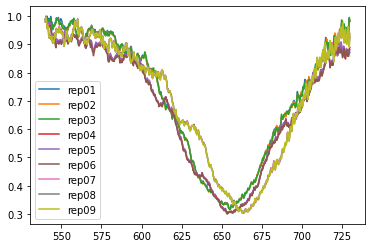

In [17]:
import data_process as dp
import pandas as pd
testfile = "./sampledata/HAN24/2021-11-04-HAN24-Beer-01.tsv"
df = pd.read_csv(testfile, sep='\t')

# df = df[['wavelength', 'rep01', 'rep02','rep03']]

df = dp.trim_df(df, wl_min=540, wl_max=730)
df = dp.normalise_df(df)
df = dp.resample_df(df, resample=0.3)

dp.plot_df(df)
